This notebook tests the run_epoch, eval_network and train_network functions in tools.py, which cover exercises 2, 3 and 4.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torcheval.metrics

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import seaborn as sns

import time
import os
import sys
sys.path.append('..')
from tools import *

assert(torch.cuda.is_available())
device = torch.device("cuda")

c:\Users\Miguel\miniconda3\envs\ml3\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


<Axes: >

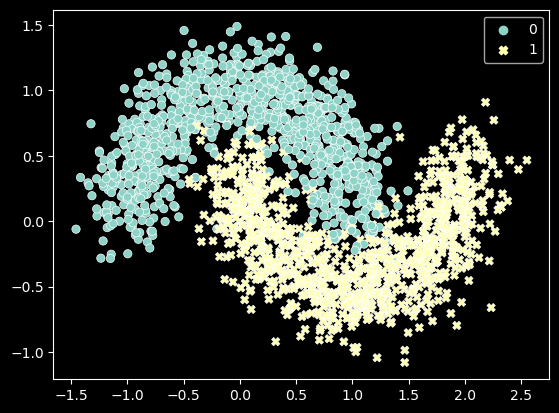

In [2]:
X, y = make_moons(n_samples=10000, noise=0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
sns.scatterplot(x=X_test[:,0], y=X_test[:,1], hue=y_test, style=y_test)

In [3]:
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long)
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.long)
)
training_loader_32 = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
# training_loader_256 = DataLoader(train_dataset, batch_size=256, shuffle=True, pin_memory=True)
testing_loader_32 = DataLoader(test_dataset, batch_size=32, shuffle=True, pin_memory=True)

model = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2),
).to(device)

optimizer = torch.optim.AdamW(model.parameters())
f_loss = torch.nn.functional.cross_entropy

In [4]:
y0_hat = model(train_dataset[:50][0].to(device))
y0 = train_dataset[:50][1].to(device)
print(y0_hat.shape)
print(y0.shape)

torch.Size([50, 2])
torch.Size([50])


In [5]:
#our classifier returns a [batch_len, n_classes] tensor of logits. but the
#torcheval metrics expect a [batch_len,] tensor of integer class labels, so we
#need to apply argmax along each row of the classifier output to get the
#predicted class
print(torcheval.metrics.functional.binary_accuracy( torch.argmax(y0_hat, axis=1) , y0))
print(torcheval.metrics.functional.binary_f1_score( torch.argmax(y0_hat, axis=1) , y0))

tensor(0.6400, device='cuda:0')
tensor(0.5500, device='cuda:0')


In [6]:
#to apply this preprocessing automatically to any metric functional, we pass the
#functional to the from_logits wrapper and use the wrapped functional
binary_accuracy_from_logits = from_logits(torcheval.metrics.functional.binary_accuracy)
binary_f1_from_logits = from_logits(torcheval.metrics.functional.binary_f1_score)
print(binary_accuracy_from_logits(y0_hat, y0))
print(binary_f1_from_logits(y0_hat, y0))

metrics = {"Loss": f_loss, "Accuracy": binary_accuracy_from_logits, "F1 Score": binary_f1_from_logits}
eval_loaders = {"Train": training_loader_32, "Test": testing_loader_32}

tensor(0.6400, device='cuda:0')
tensor(0.5500, device='cuda:0')


In [7]:
results = train_network( model, optimizer, f_loss, training_loader_32, eval_loaders=eval_loaders, eval_metrics=metrics, epochs=4, save_path=os.getcwd(), save_interval=2)
results

Epoch: 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]


,Last Epoch,Last Time,Train Loss,Train Accuracy,Train F1 Score,Test Loss,Test Accuracy,Test F1 Score
0,0,0.000000,0.682493,0.657750,0.582495,0.681046,0.6720,0.607186
1,1,0.359475,0.285490,0.869750,0.871294,0.279692,0.8735,0.877125
2,2,0.346824,0.265177,0.888500,0.886283,0.253078,0.8880,0.887324
3,3,0.336633,0.208958,0.918125,0.916165,0.195204,0.9270,0.926039
4,4,0.335097,0.148996,0.950625,0.951623,0.137179,0.9540,0.955296


In [8]:
model_new = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2),
).to(device)

optimizer_new = torch.optim.AdamW(model_new.parameters())

In [9]:
results = train_network( model_new, optimizer_new, f_loss, training_loader_32, eval_loaders=eval_loaders, eval_metrics=metrics, epochs=4, save_path=os.getcwd(), load_file="checkpoint_epoch4.pt")
results

Epoch: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


,Last Epoch,Last Time,Train Loss,Train Accuracy,Train F1 Score,Test Loss,Test Accuracy,Test F1 Score
0,4,0.335097,0.148996,0.950625,0.951623,0.137179,0.9540,0.955296
1,5,0.383697,0.114576,0.960750,0.960183,0.099870,0.9675,0.967254
2,6,0.379678,0.103113,0.961125,0.960518,0.086562,0.9720,0.971717
3,7,0.375846,0.092506,0.966125,0.965925,0.075976,0.9730,0.973000
4,8,0.377298,0.086948,0.967125,0.967121,0.072464,0.9730,0.973134
